In [1]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt

from fcn import FCNet
from data_utils import SegmentationCOCOSet
from torch.utils.data import DataLoader
from trainer import FCNSegmentationTrainer
from torchvision.transforms.v2 import Resize
from torch.nn import ModuleList
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import draw_segmentation_masks

plt.style.use("dark_background")

In [2]:
tf = Resize(size=(128, 128))

In [3]:
trainset = SegmentationCOCOSet(
    data_dir="C:\\Users\\1\\Downloads\\segmes.v18i.coco-segmentation",
    data_split="train",
    images_size=(128, 128)
)

In [4]:
model = FCNet(
    in_channels=3, 
    h_channels=128, 
    classes_n=trainset.classes_n
)

In [5]:
test_in = th.normal(0.12, 1.21, (1, 3, 128, 128))
x = test_in
for (name, params) in model.named_children():
    
    if "down" in name:
        x = params(x)
        print(tf(x).size())
        

torch.Size([1, 128, 128, 128])
torch.Size([1, 64, 128, 128])
torch.Size([1, 32, 128, 128])
torch.Size([1, 128, 128, 128])


In [6]:
trainer = FCNSegmentationTrainer(
    run_folder="C:\\Users\\1\\Desktop\\PythonProjects\\DASLMTelegramBot\\test\\segmentation\\storage_segmentation",
    model=model,    
    train_set=trainset,
    epochs=10
)

 10%|█         | 1/10 [00:20<03:07, 20.85s/it]

Epoch: [0], Loss: [10.880961418151855]


 20%|██        | 2/10 [00:38<02:33, 19.22s/it]

Epoch: [1], Loss: [10.177909851074219]


 30%|███       | 3/10 [00:58<02:17, 19.60s/it]

Epoch: [2], Loss: [9.987832069396973]


 40%|████      | 4/10 [01:20<02:01, 20.33s/it]

Epoch: [3], Loss: [9.864283561706543]


 50%|█████     | 5/10 [01:42<01:44, 20.98s/it]

Epoch: [4], Loss: [9.761022567749023]


 60%|██████    | 6/10 [02:03<01:23, 20.95s/it]

Epoch: [5], Loss: [9.664796829223633]


 70%|███████   | 7/10 [02:23<01:01, 20.66s/it]

Epoch: [6], Loss: [9.63754653930664]


 80%|████████  | 8/10 [02:44<00:41, 20.79s/it]

Epoch: [7], Loss: [9.558967590332031]


 90%|█████████ | 9/10 [03:03<00:20, 20.19s/it]

Epoch: [8], Loss: [9.489707946777344]


100%|██████████| 10/10 [03:23<00:00, 20.35s/it]

Epoch: [9], Loss: [9.439263343811035]


{'loss': [tensor(10.8810, grad_fn=<AddBackward0>),
  tensor(10.1779, grad_fn=<AddBackward0>),
  tensor(9.9878, grad_fn=<AddBackward0>),
  tensor(9.8643, grad_fn=<AddBackward0>),
  tensor(9.7610, grad_fn=<AddBackward0>),
  tensor(9.6648, grad_fn=<AddBackward0>),
  tensor(9.6375, grad_fn=<AddBackward0>),
  tensor(9.5590, grad_fn=<AddBackward0>),
  tensor(9.4897, grad_fn=<AddBackward0>),
  tensor(9.4393, grad_fn=<AddBackward0>)]}

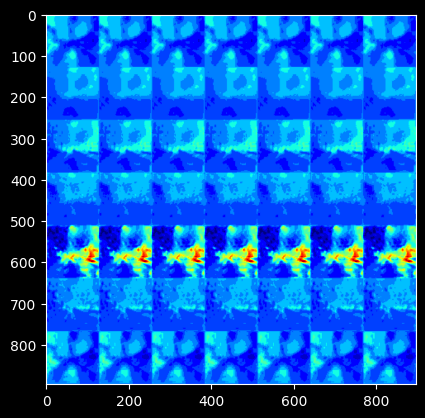

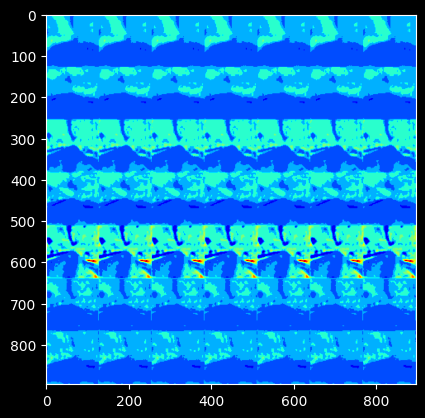

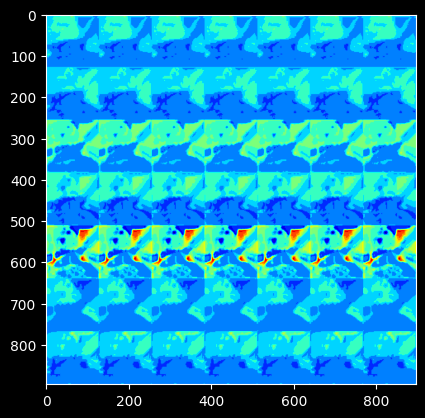

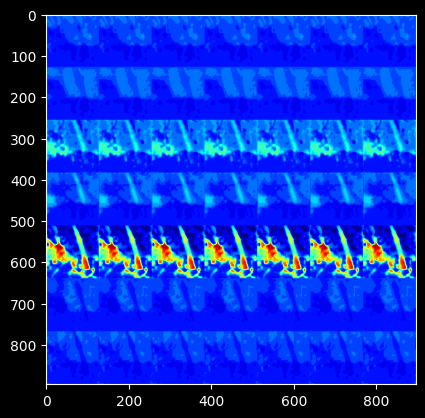

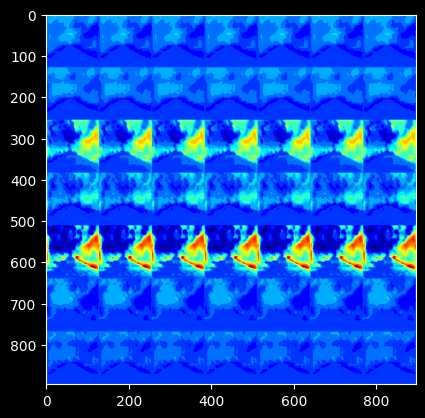

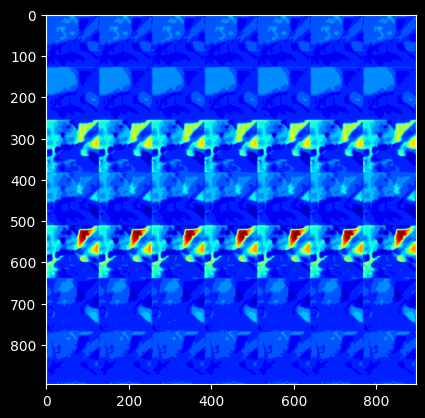

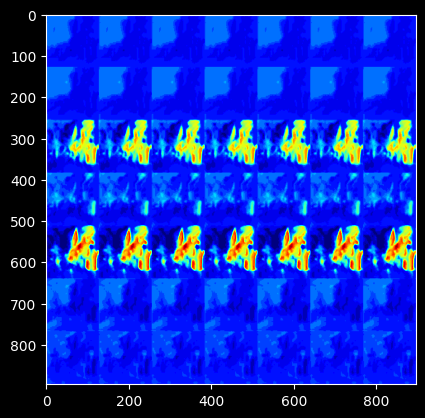

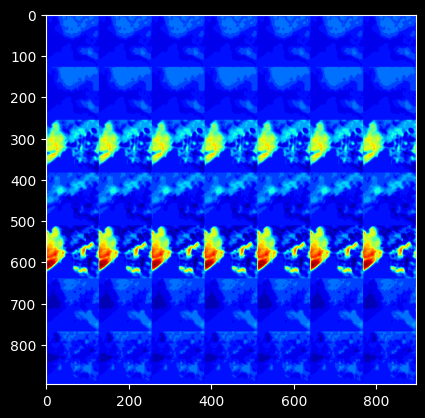

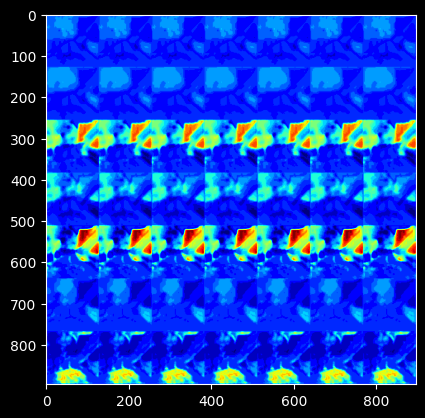

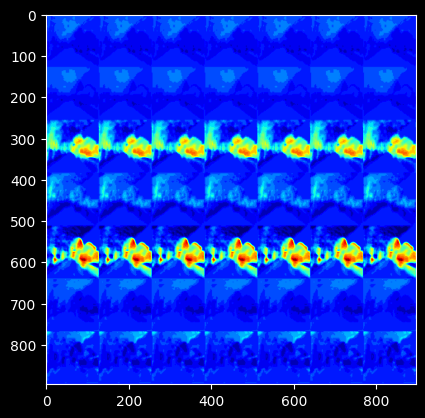

In [7]:
trainer.train() 

In [16]:
model.load_state_dict(th.load(
    f="C:\\Users\\1\\Desktop\\PythonProjects\\DASLMTelegramBot\\test\\segmentation\\storage_segmentation\\model_params.pt",
    weights_only=True
))

<All keys matched successfully>

In [17]:
BATCH_SIZE = 32
test_loader = DataLoader(dataset=trainset, batch_size=32, shuffle=True)

In [18]:
images, segmentation_masks= next(iter(test_loader))
print(images.size(), segmentation_masks.size())

torch.Size([32, 3, 128, 128]) torch.Size([32, 45, 128, 128])


In [19]:
print(th.max(segmentation_masks[2]))

tensor(1.)


In [20]:
model_out = model(images)
print(th.max(model_out), th.mean(model_out), th.min(model_out))
model_out[model_out > th.mean(model_out).item()] = 1.0
model_out[model_out < th.mean(model_out).item()] = 0.0

tensor(0.1300, grad_fn=<MaxBackward1>) tensor(0.0222, grad_fn=<MeanBackward0>) tensor(0.0043, grad_fn=<MinBackward1>)


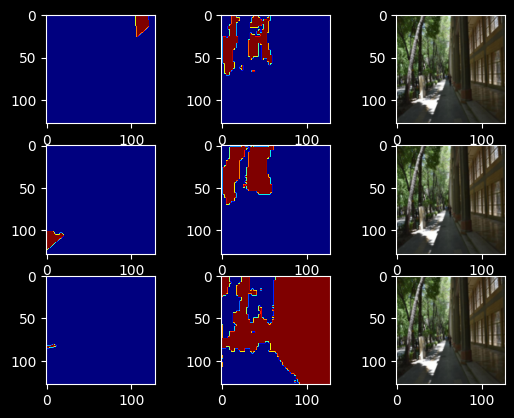

In [22]:
rd_idx = th.randint(0, 32, (1, )).item()
samples = []
for n in range(42):
    if th.max(segmentation_masks[rd_idx, n, :, :]) > 0.0:
        samples.append(np.array(to_pil_image(segmentation_masks[rd_idx, n, :, :])))

if len(samples) > 1:

    _, axis = plt.subplots(nrows=3, ncols=3)
    for i in range(3):
        axis[i, 0].imshow(samples[i], cmap="jet")
        axis[i, 1].imshow(np.asarray(to_pil_image(model_out[rd_idx, i, :, :])), cmap="jet")
        axis[i, 2].imshow(np.asarray(to_pil_image(images[rd_idx, :, :, :])))

elif len(samples) > 0:
    _, axis = plt.subplots()
    axis.imshow(samples[0], cmap="jet")


plt.show()


In [23]:
colors = [
    th.randint(0, 256, (3, )).tolist()
    for _ in range(45)
]

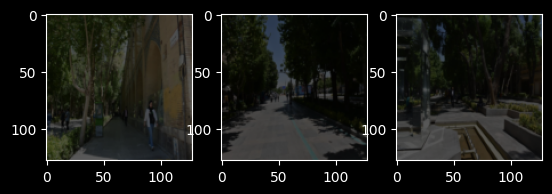

In [30]:
_, axis = plt.subplots(ncols=3)
for i in range(3):

    idx =  th.randint(0, 32, (1,)).item()
    image = images[idx, :, :, :]
    image = draw_segmentation_masks(image, model_out[idx, :, :, :].to(th.bool), colors=colors, alpha=0.65)
    axis[i].imshow(np.asarray(to_pil_image(image)))

plt.show()